Case 2a: Nickel strip with circular cut profile with the center of the circles on the strips

The case describes a nickel strip having a cut profile as such:

![](IMG_0745.jpg)

With variable width profiles, we will have to modify the equation such that the total resistance takes into account the infinitesimal difference in widths, since electrical resistance is a function of cross sectional area. The equation then becomes:

$$\frac{I^2\rho_r\Delta{t}}{h}\int_0^l{\frac{1}{f(x)}dx} = \rho_d\int_0^l{f(x)dx}\left(c_p\left(T_m - T_\infty\right) + L_f\right)$$

Grouping the unknowns on one side and the knowns on the other, we obtain:

$$\frac{\int_0^l{\frac{1}{f(x)}dx}}{\int_0^l{f(x)dx}} = \frac{\rho_dh^2}{I^2\rho_r\Delta{t}}\left(c_p\left(T_m - T_\infty\right) + L_f\right)$$

Be aware that the two integrals are different and cannot be simplified any further. 

Import necessary libraries:

In [9]:
import numpy as np
from math import sqrt,pi
import matplotlib.pyplot as plt

Define constants:

In [2]:
I = 50.0            # current passing through the strip [A]
rho_d = 8890.0e-9   # density of nickel [kg/mm^3]
rho_r = 0.096e-3    # electrical resistivity of nickel [Ohm*mm]
dt = 1.0            # elapsed time [s]
h = 0.2             # nickel strip thickness [mm]
w0 = 8              # nickel strip default width [mm]
cp = 465            # sp. heat capacity of nickel [J/kgK]
Tm = 1435           # melting point temperature of nickel [C]
Tamb = 20           # ambient temperature [C]
Lf = 293e3          # sp. latent heat of nickel [J/kg]

Let $y'$ be the complementary length of $y(x)$. With the shown setup, we find $y'$ to be:

$$y' = \sqrt{r^2-\left(r-x\right)^2}$$

and so:

$$y(x,r) = r - y' = r - \sqrt{r^2-\left(r-x\right)^2}$$

so we have our strip width at $x$ to be:

$$f(x,r) = 2(a + y) = w_0 - 2\sqrt{r^2-\left(r-x\right)^2} = w_0 - 2\sqrt{2rx - x^2}$$

It is found that $\int_0^l{\frac{1}{f(x)}dx}$ is a non-elementary integral, and thus no analytical solution can be found. For such, we will employ numerical integration methods, specifically Simpson's Rule. Let:

$$\frac{1}{f(x,r)} = g(x,r)$$
$$\therefore\int_0^l{\frac{1}{f(x,r)}dx}\approx G_n(r) = \frac{l}{3n}\left(g(0,r)+g(l,r)+2\sum_{i = 1}^{\frac{1}{2}n-1}g(x_{2i},r)+4\sum_{i = 1}^{\frac{1}{2}n}g(x_{2i-1},r)\right)$$

Where

$$x_i = i\Delta{x} = \frac{il}{n} = \frac{2ir}{n}$$
$$\therefore G_n(r) = \frac{2r}{3n}\left(g(0,r)+g(2r,r)+2\sum_{i = 1}^{\frac{1}{2}n-1}g\left(\frac{4ir}{n},r\right)+4\sum_{i = 1}^{\frac{1}{2}n}g\left(\frac{(4i-2)r}{n},r\right)\right)$$

And we solve for $r$.

In [3]:
# define function f(x) and g(x)

def f(x,r):
    if 2*r*x - x**2 <= 1e-15:
        return w0
    else: return w0 - 2*sqrt(2*r*x - x**2)
def g(x,r): return 1/f(x,r)

In [4]:
# define function of length, l(r)
def l(r): return 2*r

In [5]:
# define a function to perform numerical integration

def simpsons(points,size,lower_bound,upper_bound):
    result = 0
    bound = upper_bound - lower_bound
    delta_x = bound/size

    for i in range(len(points)):
        if i == 0 or i == size:
            result += points[i]
        elif i % 2 == 0:
            result += 2*points[i]
        else:
            result += 4*points[i]

    result = delta_x/3*result

    return result

We should also evaluate $\int_0^l{f(x)dx}$ which gives us the area of the face of the strip, but this is easy to calculate by hand, so no need for numerical computation. The equation for volume is given by:

$$V(r) = hA_{\text{face}} = h\left(w_0l - \pi{}r^2\right)$$

Let:

$$\frac{G_n(r)}{\frac{1}{h}V(r)} = H_n(r)$$
$$K = \frac{\rho_dh^2}{I^2\rho_r\Delta{t}}\left(c_p\left(T_m - T_\infty\right) + L_f\right)$$
$$\therefore H_n(r) = K$$

It is also important to note that we are looking for a solution that satisfies: $2r < w_0$

$$\therefore r \in \left(0,\frac{1}{2}w_0\right)

In [6]:
# define function of volume, V(r)
def V(r): return w0*l(r) - pi*r**2

# define lumped function H(r)
def H(points,r,size,lower_bound,upper_bound): return simpsons(points,size,lower_bound,upper_bound)/V(r)

In [7]:
# upper and lower limits for r
lower_limit = 0
upper_limit = 1/2*w0

We now run a convergence algorithm until we obtain an answer for r:

In [8]:
R = 2.0
K = rho_d*h**2*(cp*(Tm - Tamb) + Lf)/(I**2*rho_r*dt)
alpha = 1

# check if LHP = RHP. If not, we subtract the error and recheck until solution converges
eps = 1e-6
error = 1
k = 1
while abs(error) > eps:
    lower_bound = 0
    upper_bound = l(R)

    # divide to 100 equal points
    size = 100
    xi = np.linspace(lower_bound, upper_bound,size+1)

    points = [g(xi[i],R) for i in range(len(xi))]
    LHP = H(points,R,size, lower_bound, upper_bound)
    error = LHP - K
    R = R - alpha/k*error
    k += 1


print(f"R = {R:.3f} mm")

R = 3.961 mm


Thus, the smallest part of the strip would be: $f_{min} = w_0 - 2R$

In [9]:
f_min = w0 - 2*R
print(f"f_min = {f_min:.3f} mm")

f_min = 0.079 mm


As seen from above, $f_{min} = 0.079$ mm, which is impossibly small to handle. Therefore, this profile might not be a feasible design to use. 

For illustration purposes: Plot the graph of $H_n(r) - K$

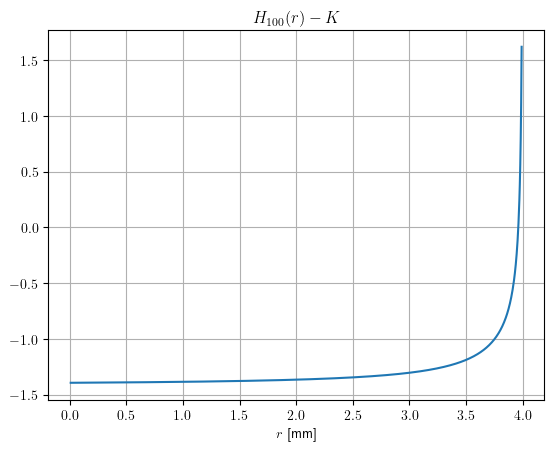

In [10]:
size_x = 100
size_r = 1000

ri = np.linspace(lower_limit + 0.01, upper_limit - 0.01, size_r+1)
points = []
y = []

for i in range(len(ri)):
    upper_bound = l(ri[i])
    xi = np.linspace(lower_bound, upper_bound,size_x+1)
    
    points_i = [g(xi[j],ri[i]) for j in range(len(xi))]
    points.append(points_i)
    y.append(H(points[i],ri[i],size_x,lower_bound,upper_bound) - K)

points = np.array(points)
y = np.array(y)

plt.rcParams['text.usetex'] = True
plt.plot(ri,y)
plt.grid(1)
plt.title("$H_{100}(r) - K$")
plt.xlabel("$r$ [mm]")
plt.show()

In [14]:
import cp_vs_T

ModuleNotFoundError: No module named 'cp_vs_T'